# This file is seeing what we get when we just apply the Random Forest directly to the Time Series

In [1]:
#pip install git+https://github.com/jakerhodes/RF-GAP-Python.git

In [2]:
# Imports
import sys
import pandas as pd
import numpy as np
from rfgap import RFGAP


# Get the data
sys.path.insert(0, '/yunity/arusty/PF-GAP')

static2025 = pd.read_csv('../data/static2025.csv')
static2022 = pd.read_csv('../data/static2022.csv')
static2024 = pd.read_csv('../data/static2024.csv')
static2023 = pd.read_csv('../data/static2023.csv')
time_series = pd.read_csv('../data/time_series.csv')
labels = pd.read_csv('../data/labels.csv')


In [3]:
# Combine the static data with the time series data
static2024.shape, time_series.shape

((496, 11), (496, 829))

In [4]:
train = np.concatenate([time_series, static2024], axis=1)
train.shape

(496, 840)

In [5]:
# Kelvyn added
label_counts = labels.value_counts().sort_index()
print(label_counts)

Labels
0         24
1         54
2         36
3         23
4         68
5         59
6         69
7         20
8         31
9         82
10        30
Name: count, dtype: int64


In [6]:
rfgap = RFGAP(prediction_type="classification", y = labels, oob_score = True)
rfgap.fit(train, labels)

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [7]:
from sklearn.ensemble import RandomForestClassifier
# Enable out-of-bag (OOB) scoring for the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state = 123, oob_score=True)

# Fit the model to the training data and labels
rf_classifier.fit(train, labels)

# Assess the OOB score
print("OOB Score:", rf_classifier.oob_score_)

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


OOB Score: 0.8125


In [8]:
rfgap.oob_score_

0.782258064516129

In [9]:
rfgap.get_proximities().todense()

matrix([[0.        , 0.00104058, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00896337, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.02930445,
         0.00080128],
        ...,
        [0.00689752, 0.00392133, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.01887589, ..., 0.        , 0.        ,
         0.00238949],
        [0.        , 0.        , 0.01605997, ..., 0.00049776, 0.01117315,
         0.        ]])

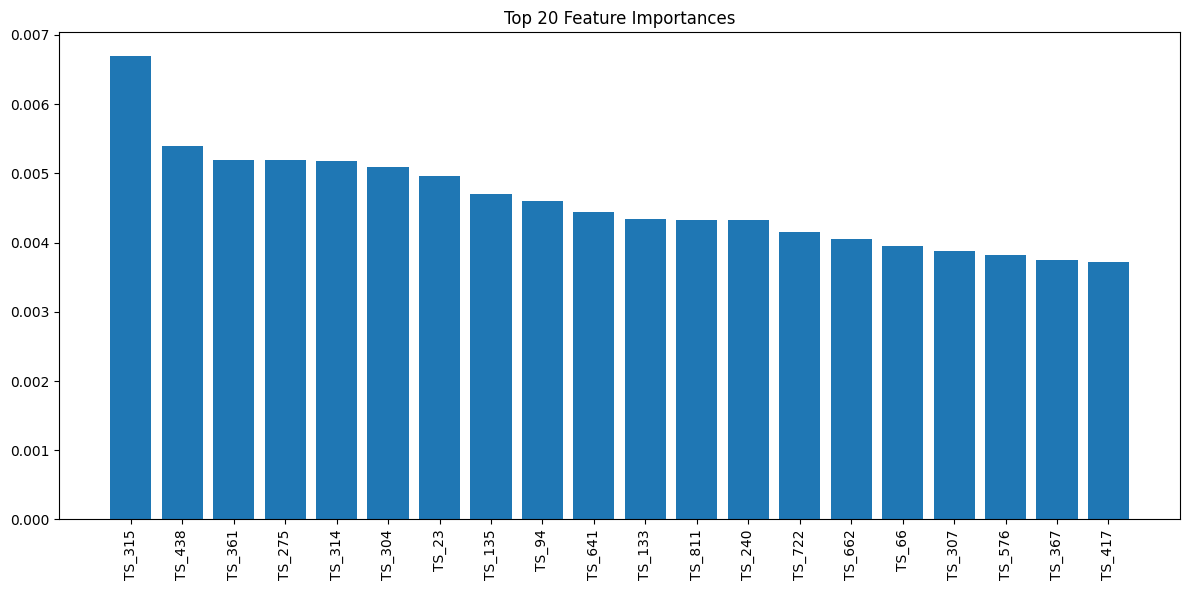

In [10]:
import matplotlib.pyplot as plt

# Get feature importances from the fitted rfgap model
importances = rfgap.feature_importances_

# Create feature names: static + time series
static_features = list(static2024.columns)
time_series_features = [f"TS_{col}" for col in time_series.columns]
feature_names = time_series_features + static_features

# Plot
plt.figure(figsize=(12, 6))
indices = np.argsort(importances)[::-1][:20]  # Top 20 features

# Color bars orange if in the last 11 features, else blue
bar_colors = [
    'orange' if indices[i] >= len(feature_names) - 11 else 'C0'
    for i in range(len(indices))
]

plt.bar(range(len(indices)), importances[indices], color=bar_colors)
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# Setting this up to get test results

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test, static2023_train, static2023_test, static2024_train, static2024_test = train_test_split(time_series, 
labels, static2023, static2024, test_size=0.2, random_state=42)

X_train = np.concatenate([X_train, static2023_train], axis=1)
X_test = np.concatenate([X_test, static2024_test], axis=1)

# Fit the model on the training set
rfgap.fit(X_train, y_train)

# Optionally, check OOB score or make predictions on X_test
print("OOB Score:", rfgap.oob_score_)
print("Test Set Score:", rfgap.score(X_test, y_test))

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


OOB Score: 0.7803030303030303
Test Set Score: 0.83


In [12]:
prox_train = np.array(rfgap.get_proximities().todense())
prox_test = np.array(rfgap.prox_extend(X_test).todense())

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Use the proximity matrices as features for KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(prox_train, y_train)
knn.score(prox_test, y_test)

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.73

# Visualizations

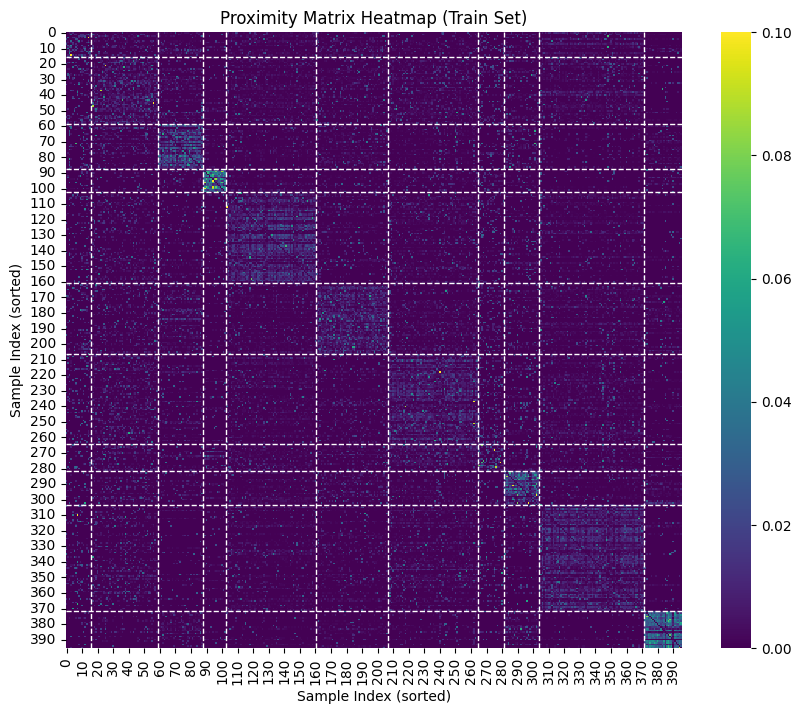

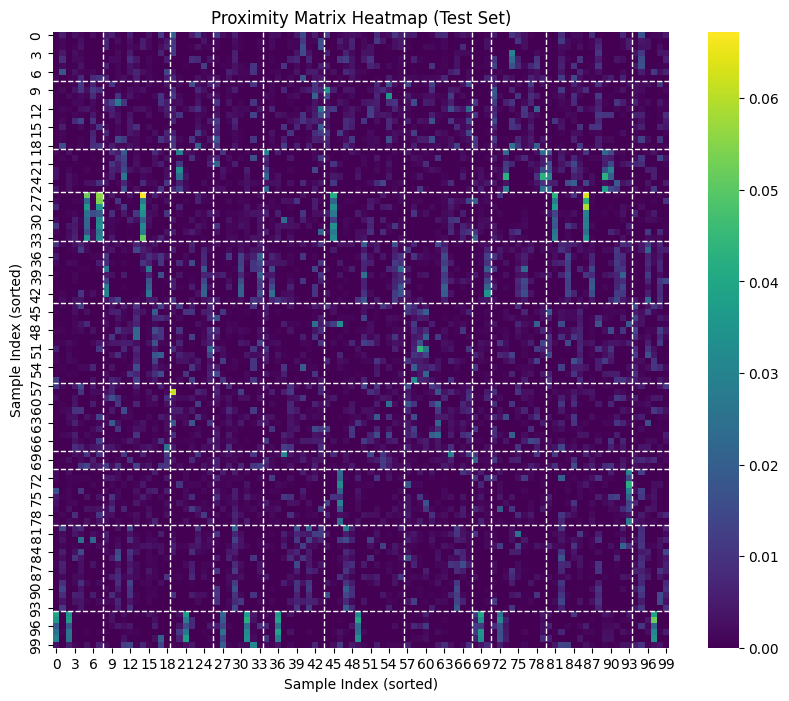

In [14]:
import seaborn as sns


def heatmap_sorted(dist_matrix, labels, title="Proximity Matrix Heatmap (Sorted by Class)"):
    sort_idx = np.argsort(labels)
    sorted_matrix = dist_matrix[sort_idx][:, sort_idx]
    sorted_labels = labels[sort_idx]
    sorted_matrix = np.clip(sorted_matrix, 0, 0.1) 
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_matrix, cmap='viridis', square=True, cbar=True)
    plt.title(title)
    plt.xlabel("Sample Index (sorted)")
    plt.ylabel("Sample Index (sorted)")

    # Find indices where the class changes
    class_change_indices = np.where(np.diff(sorted_labels) != 0)[0] + 1
    for idx in class_change_indices:
        plt.axvline(idx, color='white', linestyle='--', linewidth=1)
        plt.axhline(idx, color='white', linestyle='--', linewidth=1)

    plt.show()

heatmap_sorted(prox_train, y_train.values.flatten(), title="Proximity Matrix Heatmap (Train Set)")
heatmap_sorted(prox_test, y_test.values.flatten(), title="Proximity Matrix Heatmap (Test Set)")

In [15]:
# Get sorted indices by label
y_train = np.array(y_train).flatten()
sorted_indices = np.argsort(y_train)

# Reorder prox_train and y_train
prox_train_sorted = prox_train[sorted_indices]
sorted_y_train = y_train[sorted_indices]

#Normalize between 0 and 1
prox_train_sorted = (prox_train_sorted - prox_train_sorted.min(axis=0)) / (prox_train_sorted.max(axis=0) - prox_train_sorted.min(axis=0))

# prox_train_sorted now has rows grouped by class
prox_train_sorted.shape, sorted_y_train[:40]

((396, 396),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

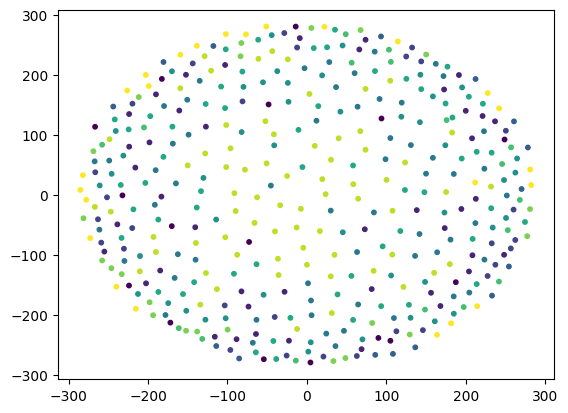

In [16]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
prox_train_sorted = 1 - prox_train_sorted
mds_result = mds.fit_transform(prox_train_sorted @ prox_train_sorted.T)
plt.scatter(mds_result[:, 0], mds_result[:, 1], c=sorted_y_train, cmap='viridis', s=10)

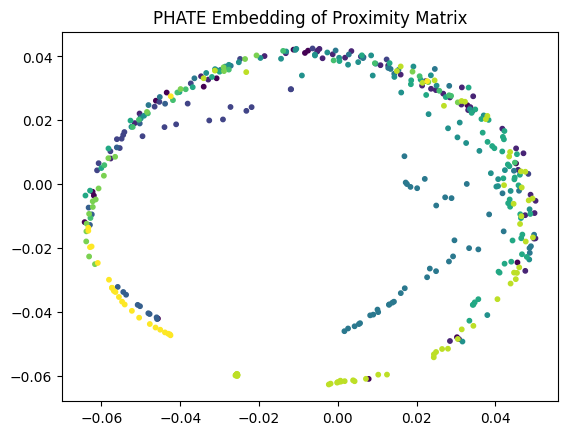

In [17]:
import phate

# PHATE expects a distance matrix, so use 1 - prox_train_sorted @ prox_train_sorted.T
phate_operator = phate.PHATE(n_components=2, knn=5, random_state=42, verbose=False)
distance_matrix = 1 - prox_train_sorted @ prox_train_sorted.T
phate_result = phate_operator.fit_transform(distance_matrix)

plt.scatter(phate_result[:, 0], phate_result[:, 1], c=sorted_y_train, cmap='viridis', s=10)
plt.title("PHATE Embedding of Proximity Matrix")
plt.show()

# Cross Validation Tests

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import pandas as pd

time_series = np.array(pd.read_csv('../data/time_series.csv'))

def determine_static(fold):
    if fold < 2:
        static_train = static2022
        static_test = static2023
    elif fold < 4:
        static_train = static2023
        static_test = static2024
    else:
        static_train = static2024
        static_test = static2025

    return np.array(static_train), np.array(static_test)

# Prepare y as 1D array for sklearn compatibility
y = labels['Labels'].values

# Set up cross-validation
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(time_series, y)):
    # Split data
    X_train, X_test = time_series[train_idx], time_series[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]

    
    static_train, static_test = determine_static(fold)

    X_train = np.concatenate([X_train, static_train[train_idx]], axis=1)
    X_test = np.concatenate([X_test, static_test[test_idx]], axis=1)
    
    # Fit Random Forest
    rfgap.fit(X_train, y_train_fold)
    y_pred_rf = rfgap.predict(X_test)
    
    # Proximity matrices for KNN
    prox_train = np.array(rfgap.get_proximities().todense())
    prox_test = np.array(rfgap.prox_extend(X_test).todense())
    
    # Fit KNN on proximities
    knn.fit(prox_train, y_train_fold)
    knn_acc = knn.score(prox_test, y_test_fold)
    
    # RF metrics
    rf_f1 = f1_score(y_test_fold, y_pred_rf, average='weighted')
    rf_recall = recall_score(y_test_fold, y_pred_rf, average='weighted')
    rf_precision = precision_score(y_test_fold, y_pred_rf, average='weighted')
    rf_acc = accuracy_score(y_test_fold, y_pred_rf)
    
    results.append({
        'fold': fold,
        # 'train_idx': train_idx,
        # 'test_idx': test_idx,
        'knn_accuracy': knn_acc,
        'rf_f1': rf_f1,
        'rf_recall': rf_recall,
        'rf_precision': rf_precision,
        'rf_accuracy': rf_acc
    })

# Convert results to DataFrame
cv_results = pd.DataFrame(results)
cv_results

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

,fold,knn_accuracy,rf_f1,rf_recall,rf_precision,rf_accuracy
0,0,0.674699,0.769293,0.783133,0.805750,0.783133
1,1,0.734940,0.774055,0.795181,0.789826,0.795181
2,2,0.686747,0.775898,0.795181,0.775818,0.795181
3,3,0.734940,0.786620,0.807229,0.788244,0.807229
4,4,0.743902,0.803985,0.817073,0.856677,0.817073
5,5,0.719512,0.761940,0.780488,0.795030,0.780488


# Kelvyn's SHAP VALUES 
- It might be helfpul to edit the above Cross Validation loop to also track the SHAP values. 
- A helpful reminder: the training data here is using both the time-series and the static data. It would be interesting to see the SHAP for them together, but if the static part adds difficulty, the feature importance shows currently that they aren't critical. 

In [22]:
#pip install shap[plots]

In [23]:
import shap

/yunity/arusty/PF-GAP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#out = rfgap.predict_proba(train[:5])
#print(type(out), np.array(out).shape)
#print(out)

In [ ]:
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(train)

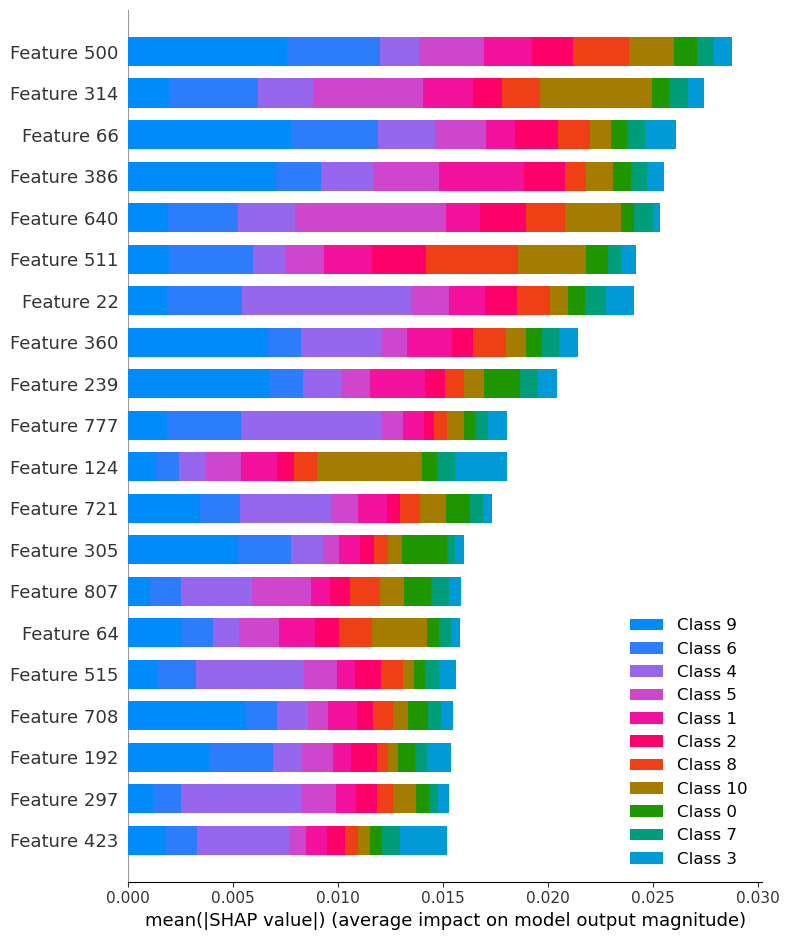

In [ ]:
shap.summary_plot(shap_values, train, plot_type="bar")

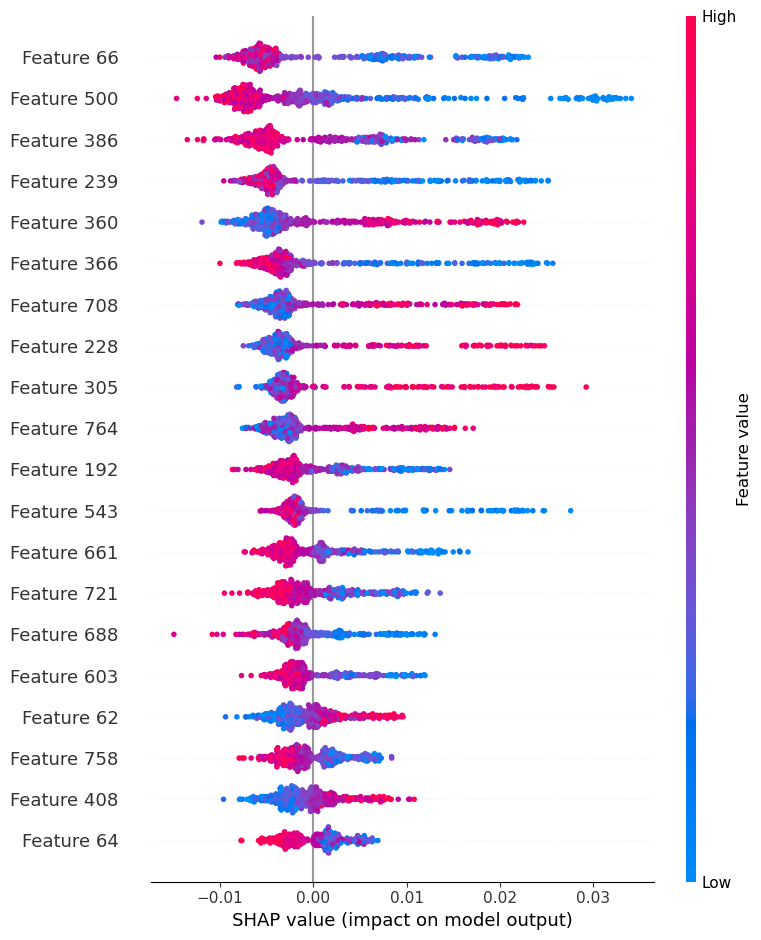

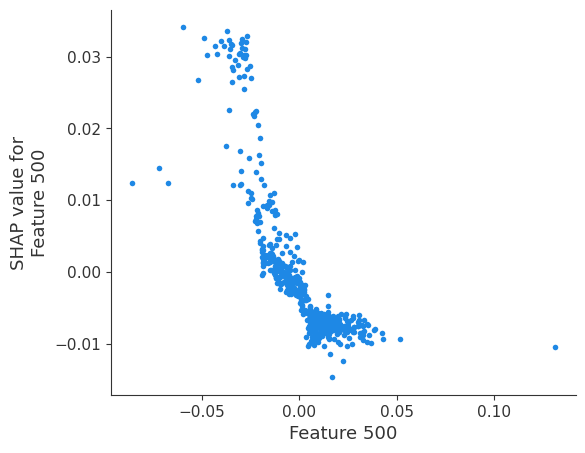

In [ ]:
#shap_values.shape, shap_values[:,:,0].shape, shap_values[1].shape, train.shape

# Focus on class 9
shap.summary_plot(shap_values[:,:,9], train)
shap.dependence_plot("Feature 500", shap_values[:,:,9], train, interaction_index=None)


# PDPs

In [ ]:
# Step 1: Select the feature and target class
feature_idx = 500
class_idx = 9

# Step 2: Create a grid of values for feature 500
grid = np.linspace(train[:, feature_idx].min(), train[:, feature_idx].max(), 50)

# Step 3: Compute average predicted probability for class 9 across the grid
avg_preds = []
for val in grid:
    temp = train.copy()
    temp[:, feature_idx] = val
    probs = rf_classifier.predict_proba(temp)
    avg_preds.append(np.mean(probs[:, class_idx]))

# Step 4: Assemble DataFrame for plotting
df_pdp = pd.DataFrame({
    'Feature_500': grid,
    'Class9_Prob': avg_preds
})

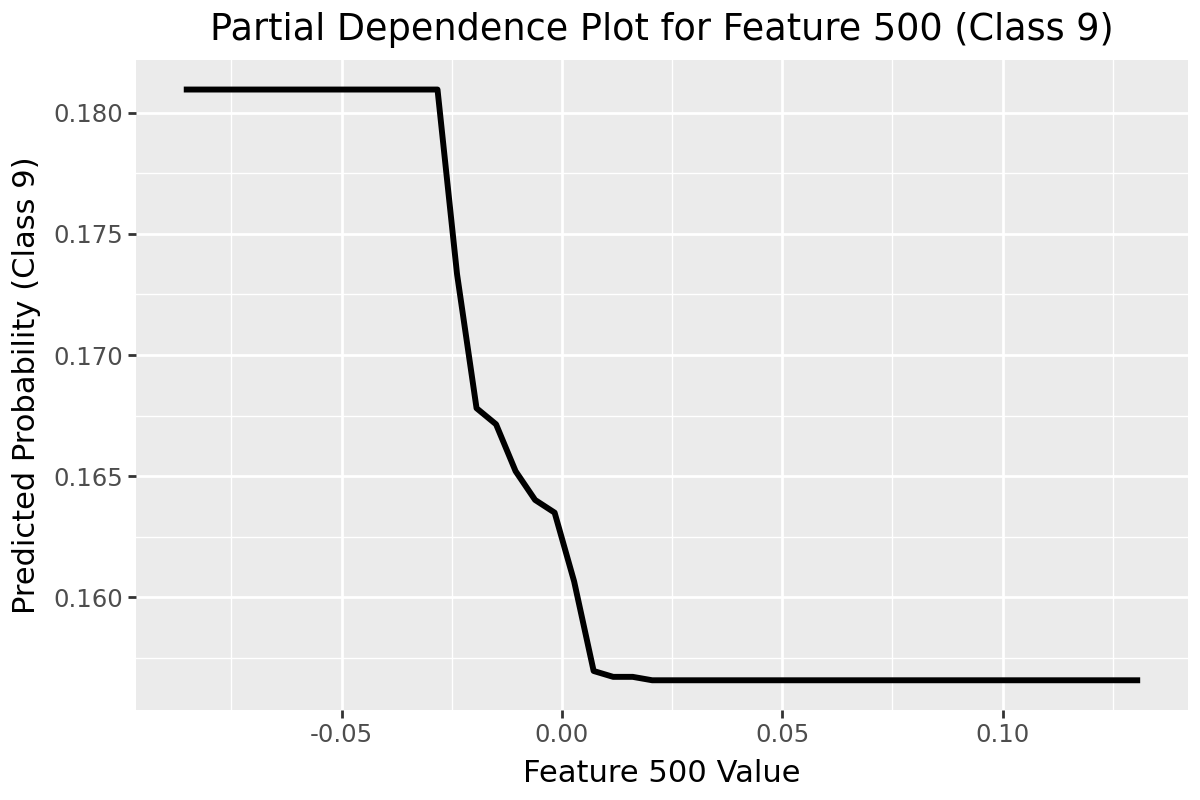

In [ ]:
p = (
    ggplot(df_pdp, aes(x='Feature_500', y='Class9_Prob')) +
    geom_line(size=1.2) +
    labs(
        title='Partial Dependence Plot for Feature 500 (Class 9)',
        x='Feature 500 Value',
        y='Predicted Probability (Class 9)'
    ) +
    theme(
        figure_size=(6, 4)
    )
)
p

# Individual TS SHAP plots

[[0.01  0.01  0.05  0.    0.06  0.785 0.02  0.015 0.02  0.02  0.01 ]]


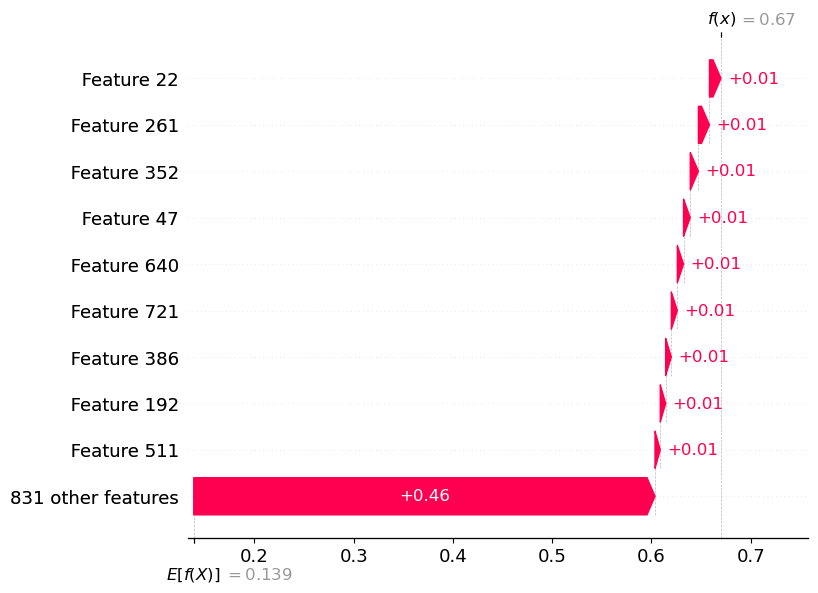

In [ ]:
# Focus on Row 0

# For class 
obs_ix = 0

predicted_probabilities = rf_classifier.predict_proba(train[2:3])
print(predicted_probabilities)

class_ix = 6

# SHAP values and feature vector for observation 0, class 9
shap_vals = shap_values[obs_ix, :, class_ix]       # shape: (n_features,)
features = train[obs_ix,:]                      # Series: feature values
base_value = explainer.expected_value[class_ix]    # scalar: expected value for class 9

shap.plots._waterfall.waterfall_legacy(base_value, shap_vals, features)

In [ ]:
from plotnine import *

# Indices
obs_ix = 0

predicted_probabilities = rf_classifier.predict_proba(train[0:1])
print(predicted_probabilities)

class_ix = 6

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'time': range(time_series.shape[1]),
    'value': train[obs_ix, 0:829],
    'shap': shap_values[obs_ix, 0:829, class_ix]
})

[[0.03  0.025 0.015 0.005 0.045 0.07  0.67  0.025 0.03  0.05  0.035]]


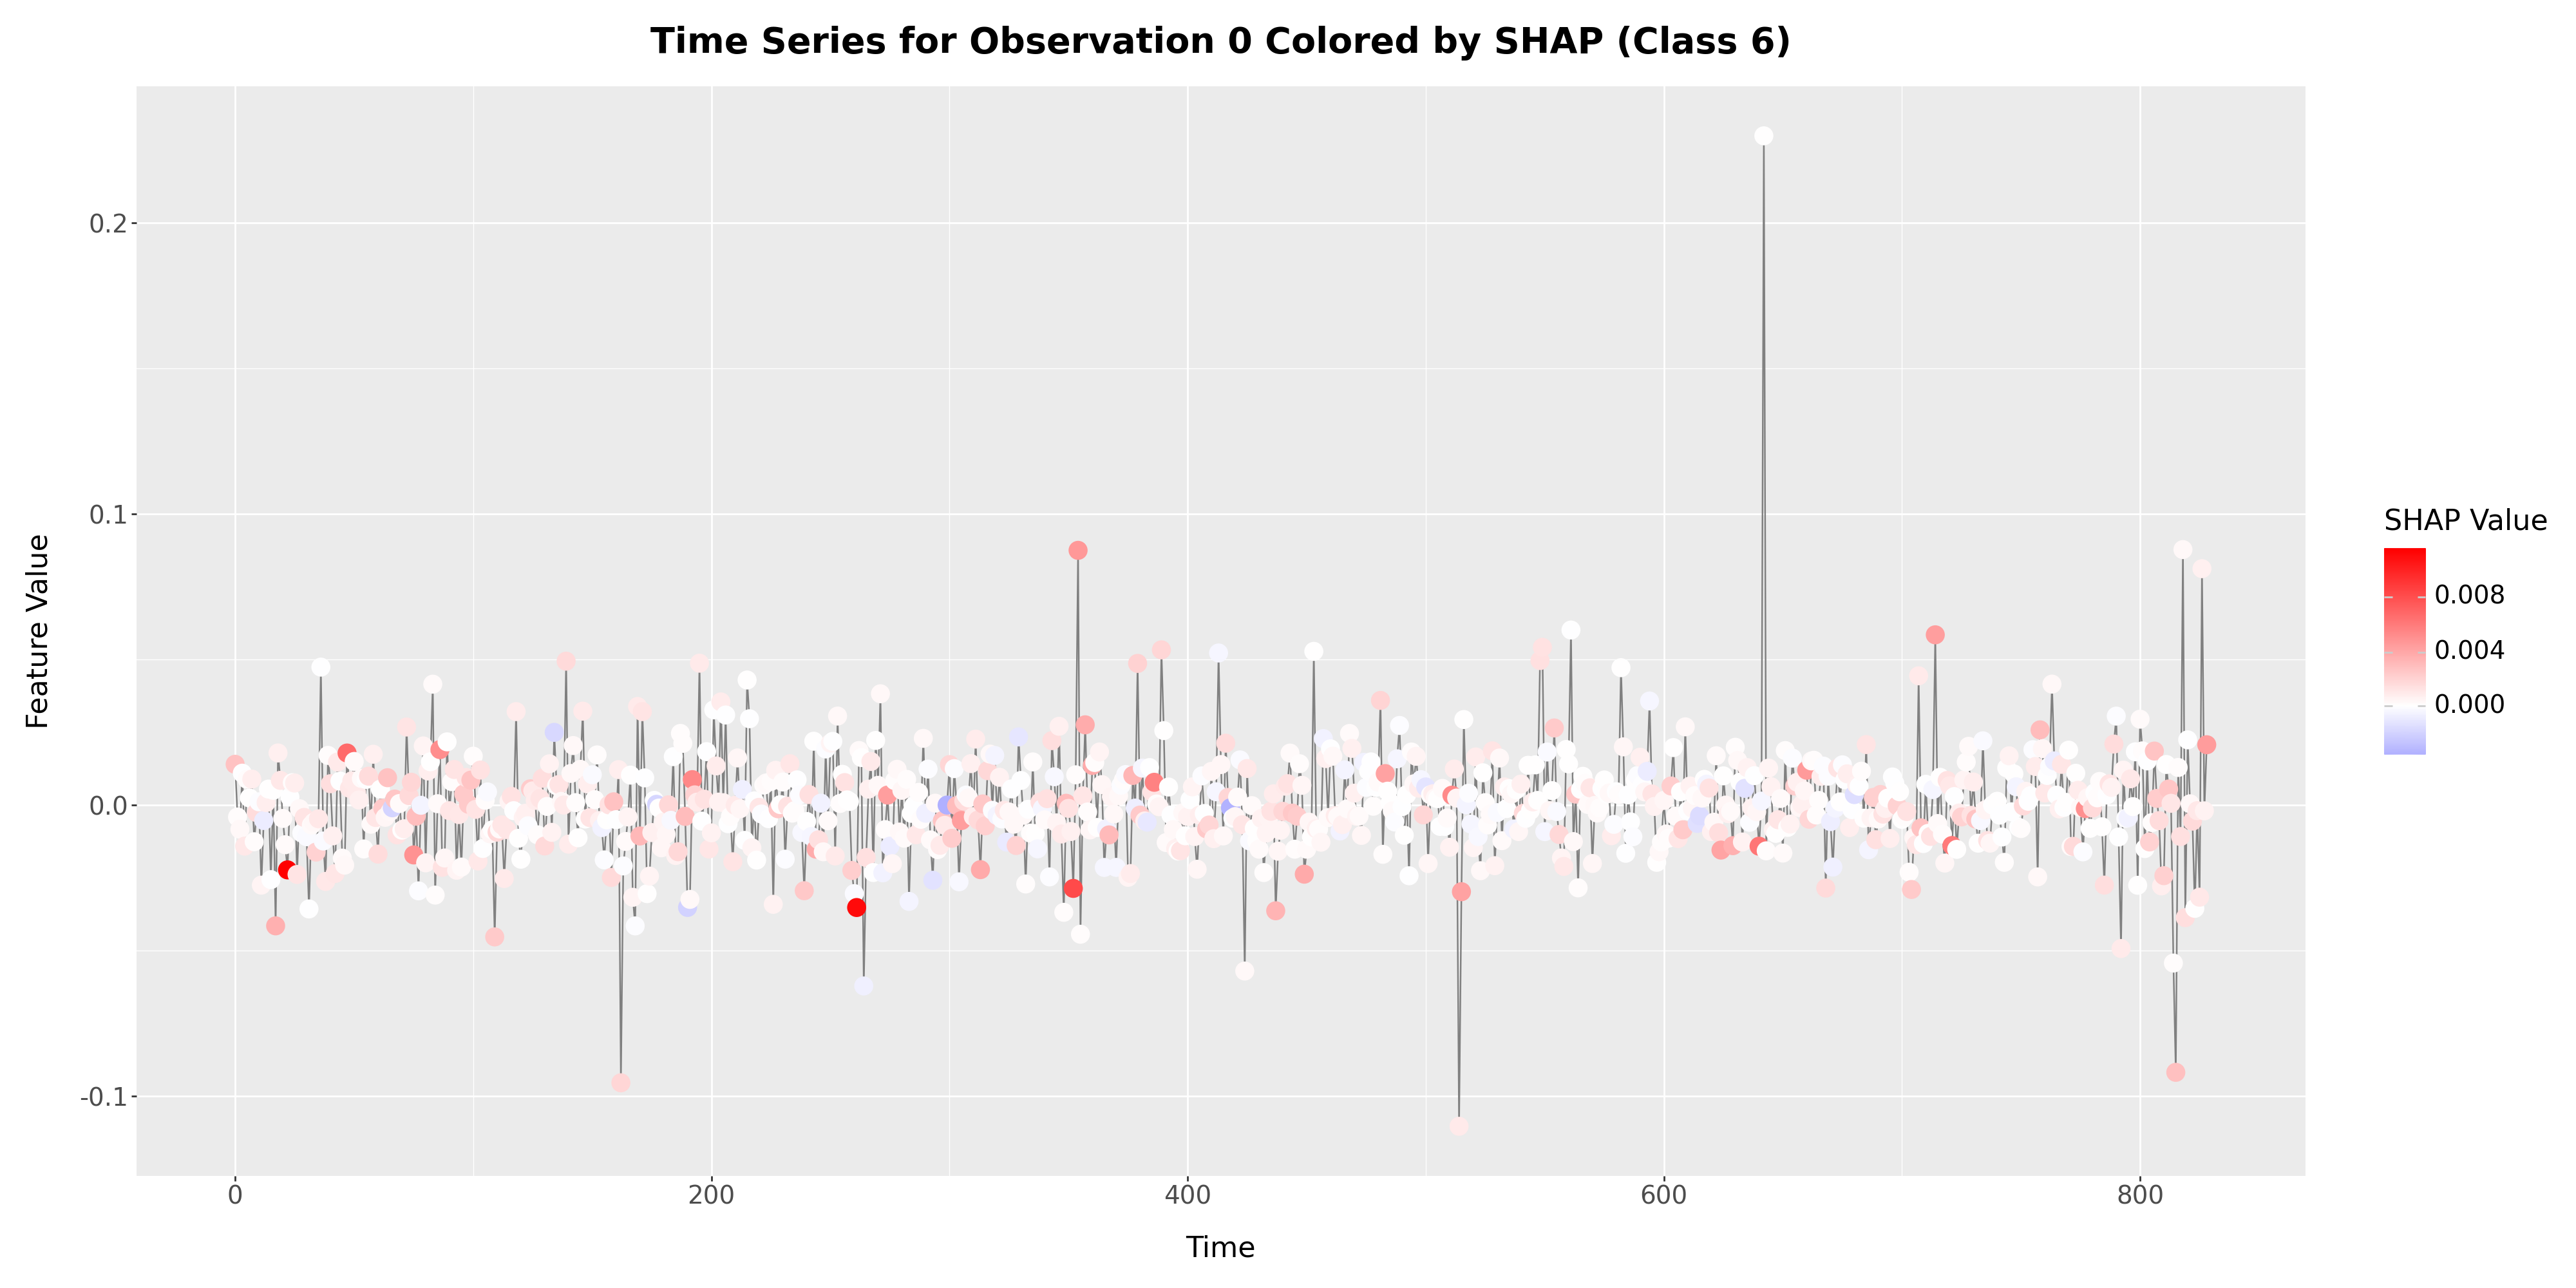

In [ ]:
# Plot using plotnine
p = (
    ggplot(df_plot, aes(x='time', y='value', color='shap')) +
    geom_line(color='gray') +
    geom_point(size = 5) +
    scale_color_gradient2(low='blue', high='red', midpoint=0) +
    labs(
        title='Time Series for Observation 0 Colored by SHAP (Class 6)',
        x='Time',
        y='Feature Value',
        color='SHAP Value'
    ) +
    theme(
        axis_text_x=element_text(size=14),
        axis_text_y=element_text(size=14),
        axis_title_x=element_text(size=16),
        axis_title_y=element_text(size=16),
        plot_title=element_text(size=20, face='bold'),
        legend_title=element_text(size=16),
        legend_text=element_text(size=14),
        figure_size=(20, 10)
    )
)

p

In [ ]:
# Indices
obs_ix = 4

predicted_probabilities = rf_classifier.predict_proba(train[4:5])
print(predicted_probabilities)

class_ix = 9

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'time': range(time_series.shape[1]),
    'value': train[obs_ix, 0:829],
    'shap': shap_values[obs_ix, 0:829, class_ix]
})

[[0.02  0.015 0.01  0.    0.045 0.02  0.02  0.015 0.025 0.825 0.005]]


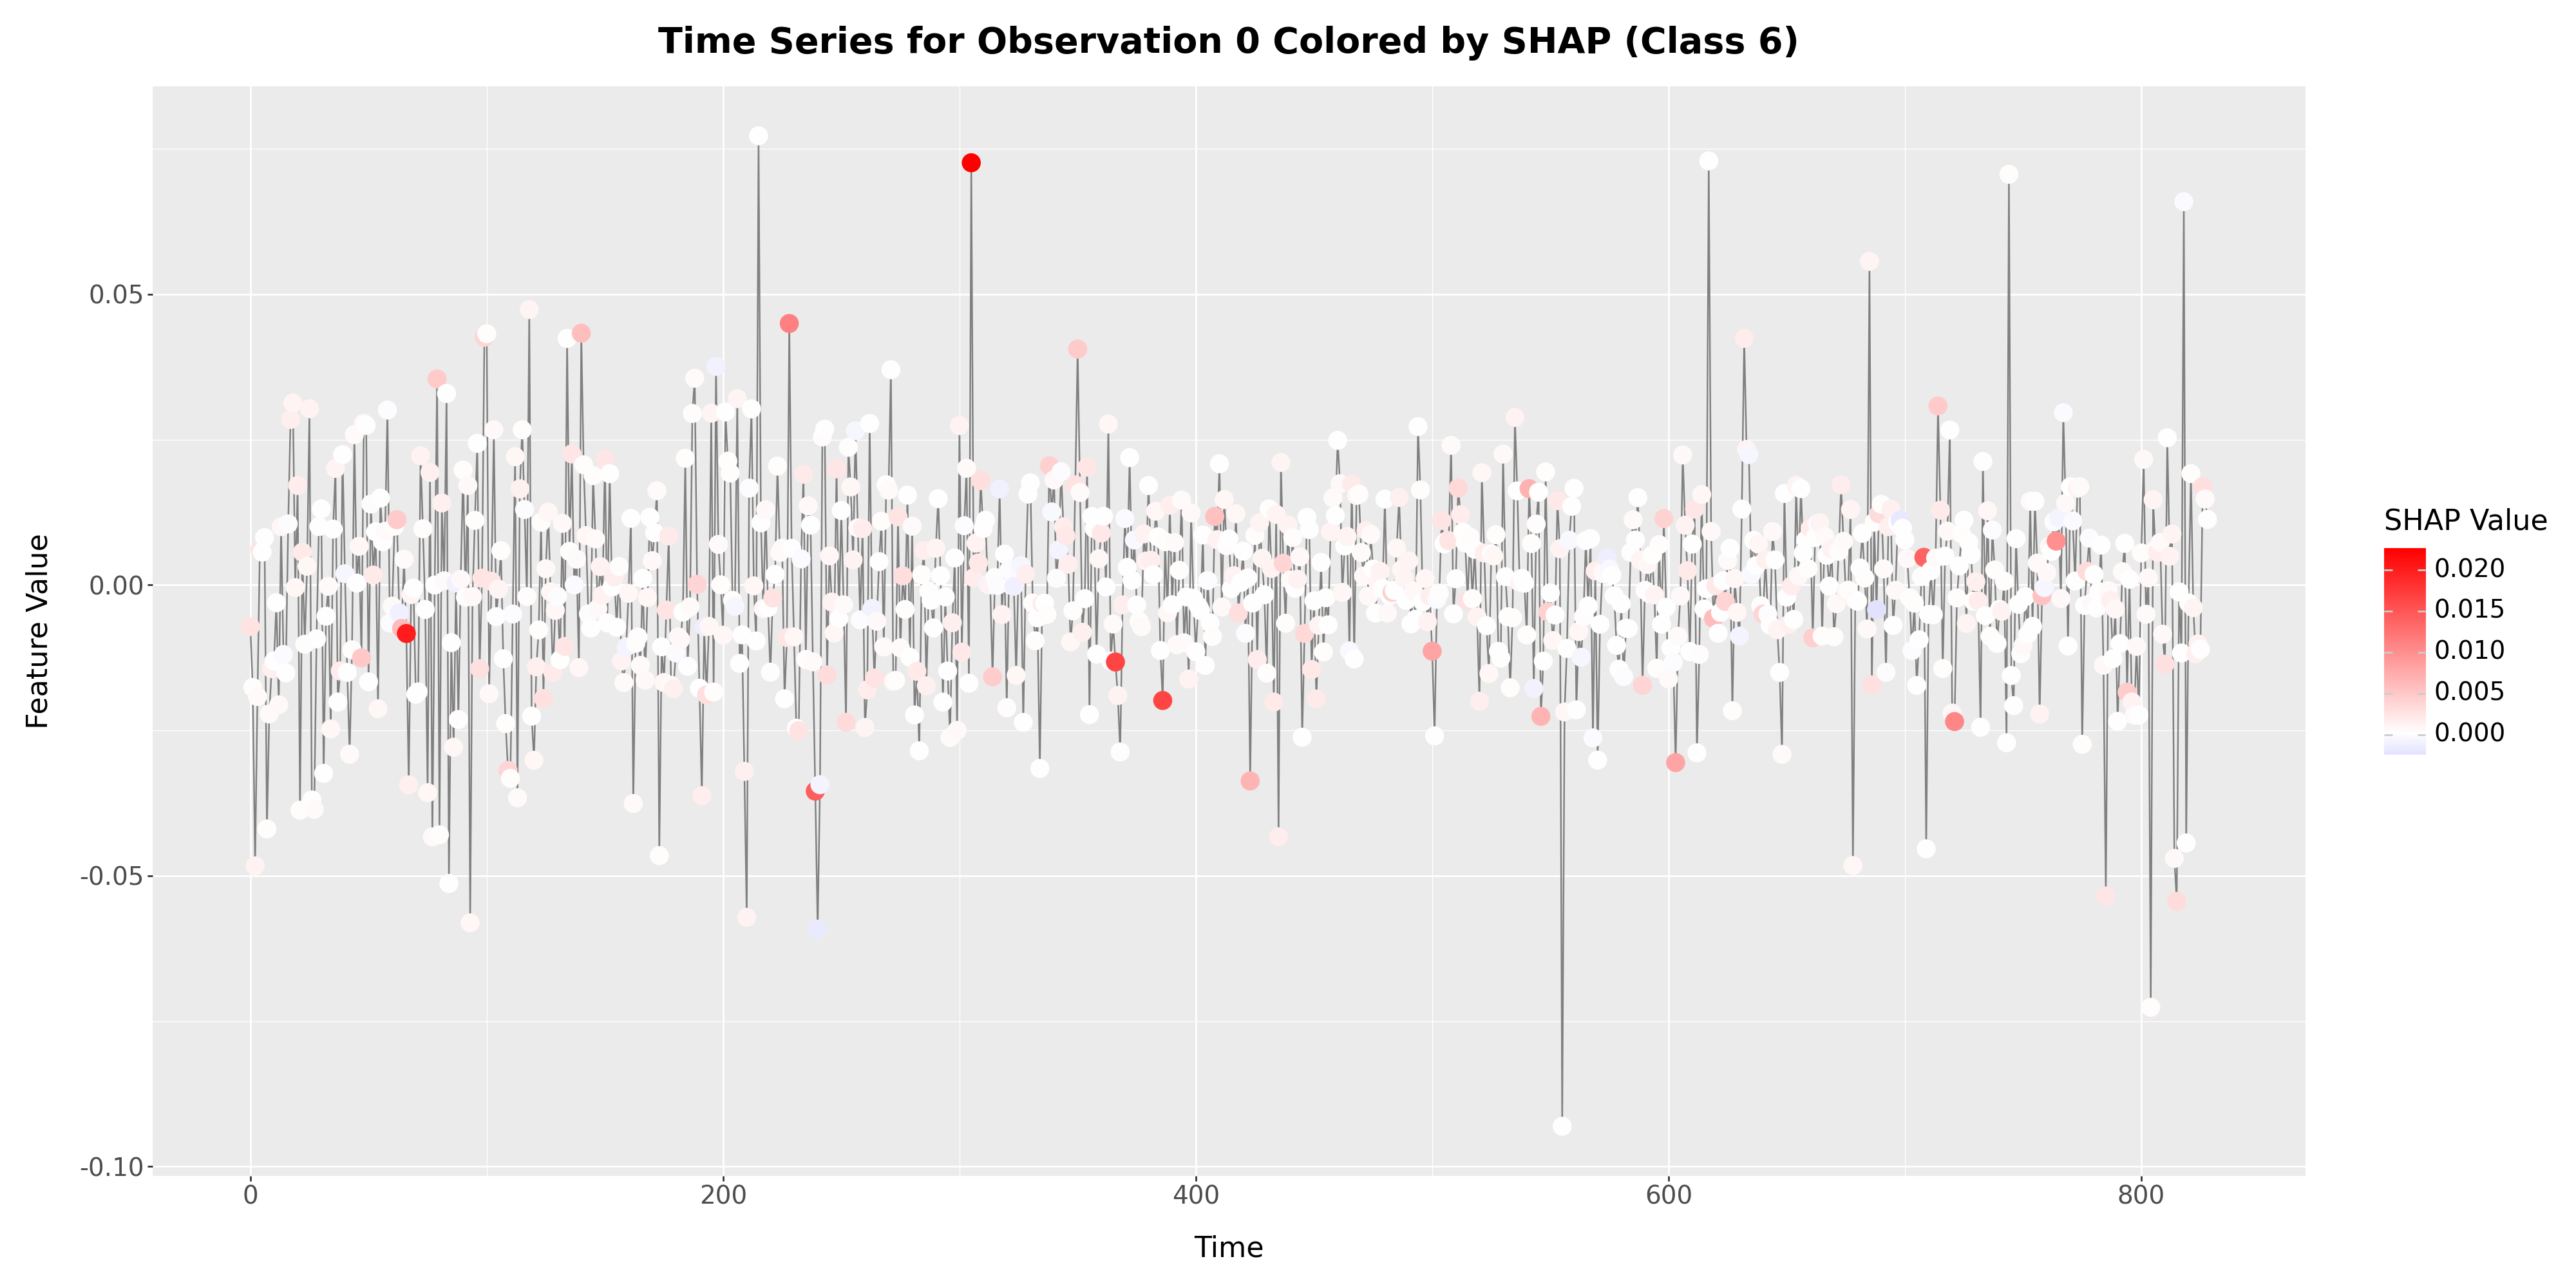

In [ ]:
p = (
    ggplot(df_plot, aes(x='time', y='value', color='shap')) +
    geom_line(color='gray') +
    geom_point(size = 5) +
    scale_color_gradient2(low='blue', high='red', midpoint=0) +
    labs(
        title='Time Series for Observation 0 Colored by SHAP (Class 6)',
        x='Time',
        y='Feature Value',
        color='SHAP Value'
    ) +
    theme(
        axis_text_x=element_text(size=14),
        axis_text_y=element_text(size=14),
        axis_title_x=element_text(size=16),
        axis_title_y=element_text(size=16),
        plot_title=element_text(size=20, face='bold'),
        legend_title=element_text(size=16),
        legend_text=element_text(size=14),
        figure_size=(20, 10)
    )
)

p

In [ ]:
# NOTE: These are loaded above, so you can comment this out. 
# NOTE: I also preformed train and tests splits above if those are helfpul for you.

# Time Series - > You may need to adjust the path based on your directory structure

# time_series = np.array(pd.read_csv('../data/time_series.csv'))

# Different years of static Variables
# static2025 = pd.read_csv('../data/static2025.csv')
# static2022 = pd.read_csv('../data/static2022.csv')
# static2024 = pd.read_csv('../data/static2024.csv')
# static2023 = pd.read_csv('../data/static2023.csv')

# Labels
# labels = pd.read_csv('../data/labels.csv')

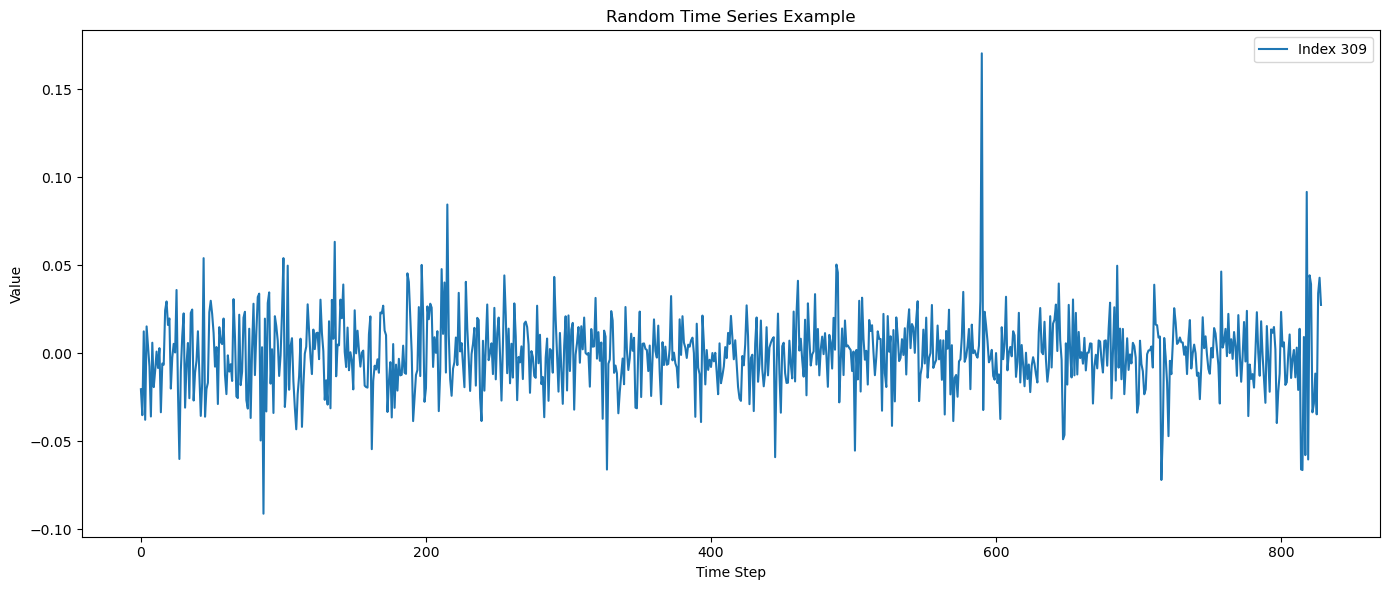

In [ ]:
# NOTE: You can delete this visualization section if you don't want it
import numpy as np
import matplotlib.pyplot as plt

# Visualize a single random time series from the dataset
# (This replaces the previous code that plotted multiple selected indices)
random_idx = np.random.choice(time_series.index)
plt.figure(figsize=(14, 6))
plt.plot(time_series.iloc[random_idx].values, label=f"Index {random_idx}")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Random Time Series Example")
plt.legend()
plt.tight_layout()
plt.show()
